In [1]:
import pandas as pd
later = pd.read_csv('./ozone_1980_ca.csv', low_memory=False)
now = pd.read_csv('./ozone_2022_ca.csv', low_memory=False)

## let's take a look what we have in our datasets:

In [2]:
later.iloc[0][later.iloc[0] == later.iloc[1]]

Source                                              AQS
Site ID                                        60010004
POC                                                   1
UNITS                                               ppm
Site Name                           Oakland-Jackson St.
DAILY_OBS_COUNT                                      17
PERCENT_COMPLETE                                  100.0
AQS_PARAMETER_CODE                                44201
AQS_PARAMETER_DESC                                Ozone
CBSA_CODE                                       41860.0
CBSA_NAME             San Francisco-Oakland-Hayward, CA
STATE_CODE                                            6
STATE                                        California
COUNTY_CODE                                           1
COUNTY                                          Alameda
SITE_LATITUDE                                 37.800484
SITE_LONGITUDE                              -122.266358
Name: 0, dtype: object

In [3]:
later.iloc[0][later.iloc[0] != later.iloc[1]]

Date                                    01/01/1980
Daily Max 8-hour Ozone Concentration         0.003
DAILY_AQI_VALUE                                  3
Name: 0, dtype: object

## well, that's a lot of info columns

## now we have to chose the key around which we will group our items.

## Let's look how many unique values are in each column:

In [4]:
for key in later.keys():
    print(key, len(later[key].unique()))
coordinates = later['SITE_LATITUDE'].astype('str') + '|' + later['SITE_LONGITUDE'].astype('str')
print('geo_loc', len(coordinates.unique()))

Date 365
Source 1
Site ID 145
POC 2
Daily Max 8-hour Ozone Concentration 229
UNITS 1
DAILY_AQI_VALUE 173
Site Name 78
DAILY_OBS_COUNT 17
PERCENT_COMPLETE 17
AQS_PARAMETER_CODE 1
AQS_PARAMETER_DESC 1
CBSA_CODE 28
CBSA_NAME 28
STATE_CODE 1
STATE 1
COUNTY_CODE 39
COUNTY 39
SITE_LATITUDE 143
SITE_LONGITUDE 143
geo_loc 143


## So, how we can see, we can use several levels of generality - 
## * CBSA (Core-based statistical area)
## * COUNTY
## * LATITUDE/LONGITUDE

## Let's count how many rows are for different latitudes.

In [5]:
from collections import Counter
Counter(later['SITE_LATITUDE']).most_common()[:3]

[(33.795848875, 692), (34.058344746, 563), (34.523328906, 381)]

# we see, that for some latitudes there are more than 365 observations per one year. This is strange, let's figure out what is happening.

In [6]:
Counter(later[later['SITE_LATITUDE'] == 33.795848875].Date).most_common()[:3]

[('01/01/1980', 2), ('01/02/1980', 2), ('01/03/1980', 2)]

In [7]:
later[(later['SITE_LATITUDE'] == 33.795848875) * (later['Date'] == '01/01/1980')]

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
16887,01/01/1980,AQS,60593002,1,0.022,ppm,20,NaN,17,100.0,44201,Ozone,31080.0,"Los Angeles-Long Beach-Anaheim, CA",6,California,59,Orange,33.795849,-118.03284
17586,01/01/1980,AQS,60596001,1,0.022,ppm,20,NaN,17,100.0,44201,Ozone,31080.0,"Los Angeles-Long Beach-Anaheim, CA",6,California,59,Orange,33.795849,-118.03284


## How we can see they differ only in Site ID, so we will need to take only one observation per day.

In [8]:
Counter(later[later['SITE_LATITUDE'] == 33.795848875].Date).most_common()[-3:]

[('12/28/1980', 2), ('12/29/1980', 2), ('12/30/1980', 2)]

## I think best idea is to group data by counties, so let's check do we have enough data for any county.

In [9]:
def f(dat):
    return len(set(dat['Date']))

later[['COUNTY', 'Date']].groupby(by='COUNTY').apply(f)

COUNTY
Alameda            365
Butte              327
Colusa              30
Contra Costa       360
El Dorado          266
Fresno             365
Glenn              357
Imperial           354
Inyo               171
Kern               362
Kings              356
Lake               237
Los Angeles        365
Marin              266
Mendocino          351
Monterey           365
Napa               347
Orange             365
Placer             364
Riverside          365
Sacramento         365
San Benito         358
San Bernardino     365
San Diego          365
San Francisco      263
San Joaquin        340
San Luis Obispo    365
San Mateo          332
Santa Barbara      365
Santa Clara        359
Santa Cruz         364
Shasta             317
Solano             365
Sonoma             352
Stanislaus         334
Sutter              44
Tulare             351
Ventura            363
Yolo               329
dtype: int64

How we see there is not enough data for most regions

Let's observe the situation for the CBSA_NAME

In [10]:
later[['CBSA_NAME', 'Date']].groupby(by='CBSA_NAME').apply(f)

CBSA_NAME
Bakersfield, CA                                  362
Bishop, CA                                       171
Chico, CA                                        327
Clearlake, CA                                    237
El Centro, CA                                    354
Fresno, CA                                       365
Hanford-Corcoran, CA                             356
Los Angeles-Long Beach-Anaheim, CA               365
Modesto, CA                                      334
Napa, CA                                         347
Oxnard-Thousand Oaks-Ventura, CA                 363
Redding, CA                                      317
Riverside-San Bernardino-Ontario, CA             365
Sacramento--Roseville--Arden-Arcade, CA          365
Salinas, CA                                      365
San Diego-Carlsbad, CA                           365
San Francisco-Oakland-Hayward, CA                365
San Jose-Sunnyvale-Santa Clara, CA               365
San Luis Obispo-Paso Robles-Arroyo G

## much better, so let's stop on grouping by the "Core-based statistical area".

## Let's look at the data from dataset of year 2022.

In [11]:
now[['CBSA_NAME', 'Date']].groupby(by='CBSA_NAME').apply(f)

CBSA_NAME
Bakersfield, CA                                  365
Bishop, CA                                       365
Chico, CA                                        362
Clearlake, CA                                    360
El Centro, CA                                    365
Eureka-Arcata-Fortuna, CA                        353
Fresno, CA                                       365
Hanford-Corcoran, CA                             364
Los Angeles-Long Beach-Anaheim, CA               365
Madera, CA                                       365
Merced, CA                                       359
Modesto, CA                                      364
Oxnard-Thousand Oaks-Ventura, CA                 365
Red Bluff, CA                                    362
Redding, CA                                      365
Riverside-San Bernardino-Ontario, CA             365
Sacramento--Roseville--Arden-Arcade, CA          365
Salinas, CA                                      365
San Diego-Carlsbad, CA              

## let's understand which columns contain data about ozone level:

In [12]:
later[['Daily Max 8-hour Ozone Concentration', 'DAILY_AQI_VALUE']].head()

,Daily Max 8-hour Ozone Concentration,DAILY_AQI_VALUE
0,0.003,3
1,0.000,0
2,0.008,7
3,0.008,7
4,0.005,5


## Finally let's group our datasets by CBSA and date. And take mean value through records with same date and cbsa:

In [13]:
_later = later[['CBSA_NAME', 'Date', 'Daily Max 8-hour Ozone Concentration']]
_later = _later.rename({'Daily Max 8-hour Ozone Concentration': 'ozone old'}, axis=1)
_later = _later.groupby(by=['CBSA_NAME', 'Date'], group_keys=False).mean().reset_index()

In [14]:
_now = now[['CBSA_NAME', 'Date', 'Daily Max 8-hour Ozone Concentration']]
_now = _now.rename({'Daily Max 8-hour Ozone Concentration': 'ozone new'}, axis=1)
_now = _now.groupby(by=['CBSA_NAME', 'Date'], group_keys=False).mean().reset_index()

## Now we need to split the year from date for correct joining

In [15]:
_later['Date'] = _later.Date.apply(lambda i: i[:-4], 1)

In [16]:
_now['Date'] = _now.Date.apply(lambda i: i[:-4], 1)

In [17]:
old_new = pd.merge(_later, _now, on=['CBSA_NAME','Date'], how='inner')

In [18]:
by_cbsa = old_new.groupby(by='CBSA_NAME', group_keys=False).mean().reset_index()

/var/folders/xy/jxf0z1nn79303dmzyqcr9x5c0000gn/T/ipykernel_94502/1879218553.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_cbsa = old_new.groupby(by='CBSA_NAME', group_keys=False).mean().reset_index()


In [19]:
from scipy.stats import mannwhitneyu

In [20]:
old_new['ozone old'].mean(), old_new['ozone new'].mean()

(0.04131816321908146, 0.04066461129849765)

## How we see, there is improvment between year 1980 and 2022, however this difference can be statistically insignificant

In [21]:
mannwhitneyu(x=by_cbsa['ozone old'], y=by_cbsa['ozone new'], alternative='less')

MannwhitneyuResult(statistic=330.0, pvalue=0.445413066786919)

## Bad result:(

## However let's take a look for pvalue if we will not take mean by days for each area:

In [22]:
mannwhitneyu(x=old_new['ozone old'], y=old_new['ozone new'], alternative='less')

MannwhitneyuResult(statistic=33831738.0, pvalue=4.1936913983298963e-22)

## Well, we see that pvalue is almost zero, if we will take in account different days.

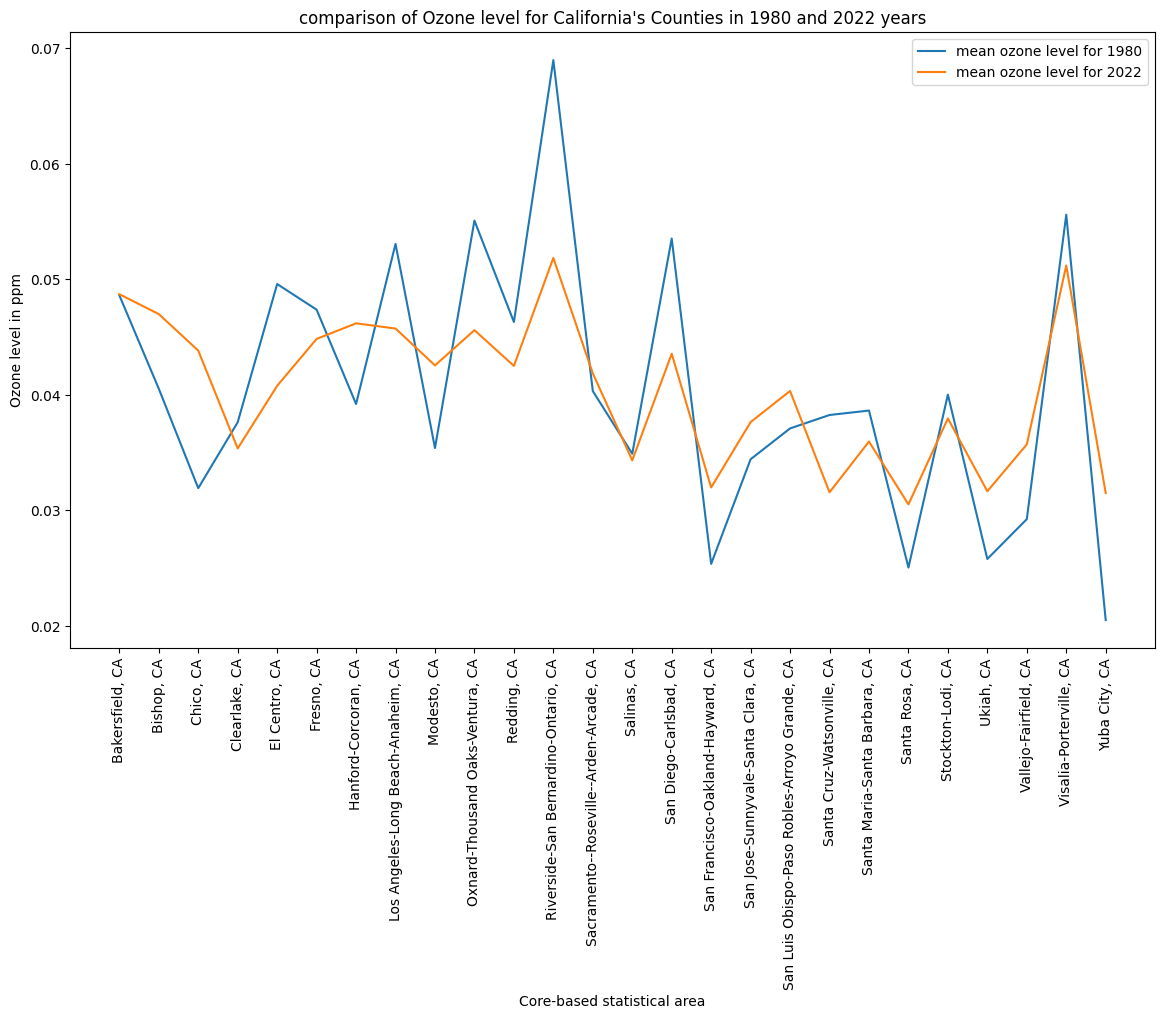

In [23]:
import matplotlib.pyplot as plt
plt.plot(by_cbsa['ozone old'], label='mean ozone level for 1980')
plt.plot(by_cbsa['ozone new'], label='mean ozone level for 2022')
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.xticks(ticks=list(range(by_cbsa.shape[0])), labels=list(by_cbsa['CBSA_NAME']), rotation=90)
plt.xlabel('Core-based statistical area')
plt.ylabel('Ozone level in ppm')
plt.title('comparison of Ozone level for California\'s Counties in 1980 and 2022 years')
plt.legend()
plt.savefig('ozone_all_counties.png', bbox_inches='tight')
plt.show()

## Let's take a look at day-by-day comparison for San Francisco county

In [24]:
set(old_new['CBSA_NAME'])

{'Bakersfield, CA',
 'Bishop, CA',
 'Chico, CA',
 'Clearlake, CA',
 'El Centro, CA',
 'Fresno, CA',
 'Hanford-Corcoran, CA',
 'Los Angeles-Long Beach-Anaheim, CA',
 'Modesto, CA',
 'Oxnard-Thousand Oaks-Ventura, CA',
 'Redding, CA',
 'Riverside-San Bernardino-Ontario, CA',
 'Sacramento--Roseville--Arden-Arcade, CA',
 'Salinas, CA',
 'San Diego-Carlsbad, CA',
 'San Francisco-Oakland-Hayward, CA',
 'San Jose-Sunnyvale-Santa Clara, CA',
 'San Luis Obispo-Paso Robles-Arroyo Grande, CA',
 'Santa Cruz-Watsonville, CA',
 'Santa Maria-Santa Barbara, CA',
 'Santa Rosa, CA',
 'Stockton-Lodi, CA',
 'Ukiah, CA',
 'Vallejo-Fairfield, CA',
 'Visalia-Porterville, CA',
 'Yuba City, CA'}

In [25]:
sf_county = 'San Francisco-Oakland-Hayward, CA'
data_for_sf_county = old_new[old_new['CBSA_NAME'] == 'San Francisco-Oakland-Hayward, CA']

In [26]:
data_for_sf_county['Date'] = data_for_sf_county['Date'].apply(lambda i: i[:-1], 1)

/var/folders/xy/jxf0z1nn79303dmzyqcr9x5c0000gn/T/ipykernel_94502/1179467510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_sf_county['Date'] = data_for_sf_county['Date'].apply(lambda i: i[:-1], 1)


In [27]:
date_list = list(data_for_sf_county['Date'])

In [28]:
month_list = [date[:-3] for date in date_list]
months = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
months_numerate = {i + 1 : months[i] for i in range(len(months))}
month_name_list = [months_numerate[int(month_num)] for month_num in month_list]

In [29]:
twelve_cons_months = [month_name_list[i * 30 + 15] for i in range(12)]

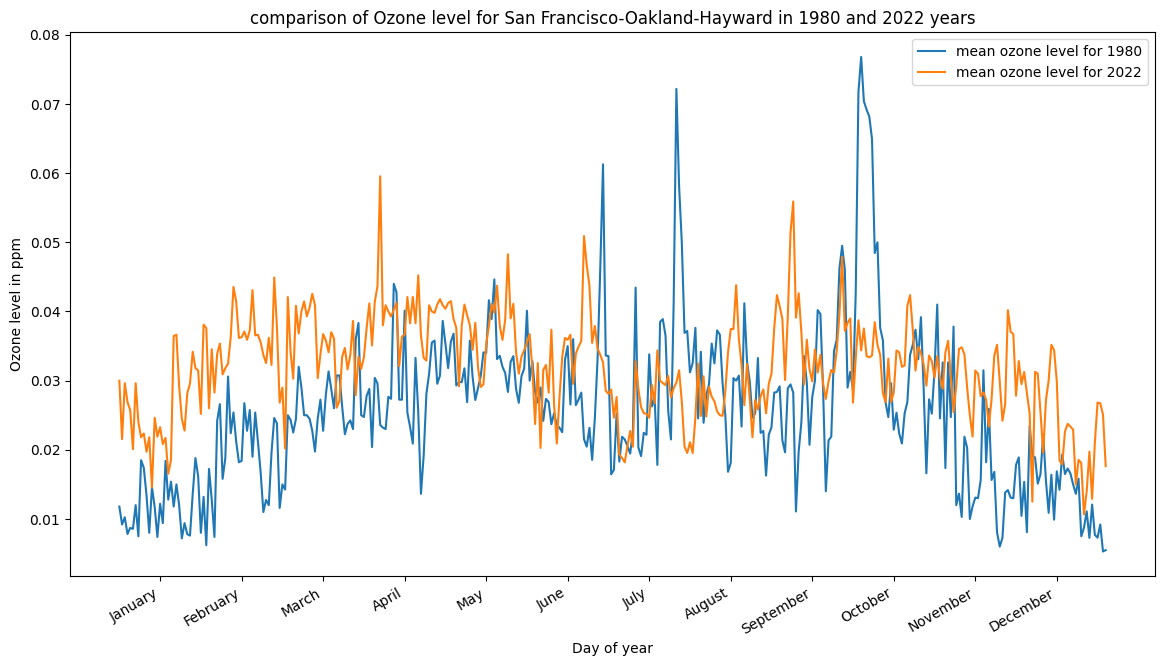

In [30]:
import matplotlib.pyplot as plt
plt.plot(list(data_for_sf_county['ozone old']), label='mean ozone level for 1980')
plt.plot(list(data_for_sf_county['ozone new']), label='mean ozone level for 2022')
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(14, 8)

plt.xticks(ticks=[i * 30 + 15 for i in range(12)], labels=twelve_cons_months, rotation=45)
ax.xaxis_date()
fig.autofmt_xdate()

plt.xlabel('Day of year')
plt.ylabel('Ozone level in ppm')
plt.title('comparison of Ozone level for San Francisco-Oakland-Hayward in 1980 and 2022 years')
plt.legend()
plt.savefig('ozone_san_fran.png', bbox_inches='tight')
plt.show()

In [31]:
!pwd

/Users/daniil/sfsu/geo160_sfsu
